# CARREGAR A BASE DE DADOS (ARQUIVOS NPY)

                                               image  coefficient
0  [[[0.3764705882352941, 0.42745098039215684, 0....         0.76
1  [[[0.19607843137254902, 0.24313725490196078, 0...         0.76
2  [[[0.3568627450980392, 0.38823529411764707, 0....         0.76
3  [[[0.28627450980392155, 0.34509803921568627, 0...         0.76
4  [[[0.2823529411764706, 0.30980392156862746, 0....         0.76


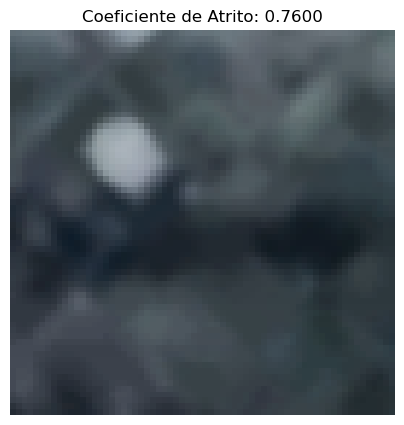

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para os arquivos .npy
images_file_path = r'C:\Users\silve\TESE\image_data.npy'  # Atualize com o caminho correto do seu arquivo
coefs_file_path = r'C:\Users\silve\TESE\coefs.npy'  # Atualize com o caminho correto do seu arquivo

# Carregar os arrays numpy dos arquivos .npy
images_array = np.load(images_file_path, allow_pickle=True)
coefs_array = np.load(coefs_file_path, allow_pickle=True)

# Reconstruir o DataFrame
df_images = pd.DataFrame({
    'image': list(images_array),  # Converter o array de imagens para uma lista de arrays
    'coefficient': coefs_array
})

# Exibir as primeiras linhas do DataFrame para confirmar a estrutura
print(df_images.head())

# Função para exibir uma imagem do DataFrame e seu coeficiente
def display_image_and_coefficient(df, index):
    # Verificar se o índice é válido
    if index < 0 or index >= len(df):
        print("Índice fora do intervalo.")
        return

    # Acessar a imagem e o coeficiente
    image_array = df.at[index, 'image']
    coefficient = df.at[index, 'coefficient']

    # Configurar a figura
    plt.figure(figsize=(5, 5))

    # Exibir a imagem
    plt.imshow(image_array)
    plt.axis('off')  # Desligar os eixos para uma visualização mais clara

    # Exibir o coeficiente de atrito como título
    plt.title(f'Coeficiente de Atrito: {coefficient:.4f}', fontsize=12)

    # Mostrar a figura
    plt.show()

# Exemplo de uso da função para exibir a imagem no índice 0 e seu coeficiente
display_image_and_coefficient(df_images, 0)


# CRIAÇÃO DOS GRUPOS DE TREINO, VALIDAÇÃO E TESTE

In [2]:
from sklearn.model_selection import train_test_split

# Dividir o DataFrame em conjunto de treino e teste
train_df, test_df = train_test_split(df_images, test_size=0.2, random_state=42)

# Dividir o conjunto de treino para criar o conjunto de validação
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f'Tamanho do conjunto de treino: {len(train_df)}')
print(f'Tamanho do conjunto de validação: {len(val_df)}')
print(f'Tamanho do conjunto de teste: {len(test_df)}')

# Função para preparar os dados
def prepare_data(df):
    """Extrai imagens e coeficientes do DataFrame e os converte em arrays numpy."""
    images = np.array(list(df['image']))  # Listar e converter para array numpy
    coefficients = np.array(df['coefficient'])
    return images, coefficients

# Preparar os dados para treino, validação e teste
X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)
X_test, y_test = prepare_data(test_df)

print(f'Forma das imagens de treino: {X_train.shape}')
print(f'Forma dos coeficientes de treino: {y_train.shape}')
print(f'Forma das imagens de validação: {X_val.shape}')
print(f'Forma dos coeficientes de validação: {y_val.shape}')
print(f'Forma das imagens de teste: {X_test.shape}')
print(f'Forma dos coeficientes de teste: {y_test.shape}')


Tamanho do conjunto de treino: 19857
Tamanho do conjunto de validação: 6619
Tamanho do conjunto de teste: 6620
Forma das imagens de treino: (19857, 66, 66, 3)
Forma dos coeficientes de treino: (19857,)
Forma das imagens de validação: (6619, 66, 66, 3)
Forma dos coeficientes de validação: (6619,)
Forma das imagens de teste: (6620, 66, 66, 3)
Forma dos coeficientes de teste: (6620,)


# PROCESSAMENTO DO MODELO

## MODELAGEM E OTIMIZAÇÃO DOS HIPERPARÂMETROS

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

class RSquared(tf.keras.metrics.Metric):
    def __init__(self, name='r_squared', **kwargs):
        super(RSquared, self).__init__(name=name, **kwargs)
        self.ss_res = self.add_weight(name='ss_res', initializer='zeros')
        self.ss_tot = self.add_weight(name='ss_tot', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        self.ss_res.assign_add(ss_res)
        self.ss_tot.assign_add(ss_tot)

    def result(self):
        return 1 - self.ss_res / (self.ss_tot + tf.keras.backend.epsilon())

    def reset_states(self):
        self.ss_res.assign(0.)
        self.ss_tot.assign(0.)

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=X_train.shape[1:]))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=[RSquared()])  # Usar R^2 como métrica
    return model

tuner = kt.RandomSearch(build_model,
                        objective=kt.Objective('val_r_squared', direction='max'),  # Maximizar R^2
                        max_trials=5,
                        executions_per_trial=1,
                        directory='my_dir',
                        project_name='mlp_coefs')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_r_squared = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Teste R^2: {test_r_squared}')

best_model.save('best_mlp_model_r_squared')


Trial 5 Complete [00h 01m 18s]
val_r_squared: -0.03183770179748535

Best val_r_squared So Far: -0.025841236114501953
Total elapsed time: 00h 57m 28s
Teste R^2: -0.02687525749206543
INFO:tensorflow:Assets written to: best_mlp_model_r_squared\assets


INFO:tensorflow:Assets written to: best_mlp_model_r_squared\assets


## REINICIALIZAÇÃO DOS HIPERPARÂMETROS (SE NECESSÁRIO)

In [7]:
import os
import shutil

# Função para limpar o diretório do projeto
def reset_project(directory, project_name):
    project_dir = os.path.join(directory, project_name)
    if os.path.exists(project_dir):
        shutil.rmtree(project_dir)
        print(f"Projeto {project_name} resetado.")

# Resetar o projeto antes de instanciar o otimizador
reset_project('my_dir', 'mlp_coefs')



Projeto mlp_coefs resetado.


## RESULTADOS DO TESTE (GRÁFICO PREDITO X REAL)

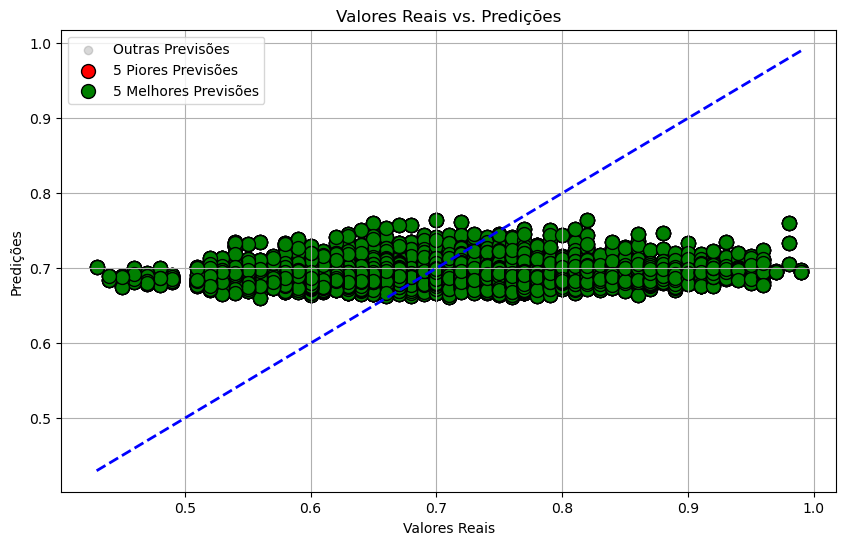

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Supondo que y_test e y_pred já estão definidos
# y_test = ...
# y_pred = ...

# Calcular os erros absolutos das previsões
errors = np.abs(y_test - y_pred)

# Obter os índices dos 5 maiores e 5 menores erros
worst_indices = np.argsort(errors)[-5:]  # Índices dos 5 maiores erros
best_indices = np.argsort(errors)[:5]  # Índices dos 5 menores erros

# Plotar os valores reais vs. preditos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label='Outras Previsões', c='grey')  # Todos os outros pontos em cinza e mais transparentes

# Destacar as 5 piores previsões em vermelho
plt.scatter(y_test[worst_indices], y_pred[worst_indices], color='red', edgecolor='k', s=100, label='5 Piores Previsões')

# Destacar as 5 melhores previsões em verde
plt.scatter(y_test[best_indices], y_pred[best_indices], color='green', edgecolor='k', s=100, label='5 Melhores Previsões')

# Linha de identidade para referência
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', lw=2)  # Linha de identidade

plt.title('Valores Reais vs. Predições')
plt.xlabel('Valores Reais')
plt.ylabel('Predições')
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


## PLOTAGEM DAS 5 MELHORES E 5 PIORES PREVISÕES DO MODELO

TypeError: Invalid shape (6620, 66, 66, 3) for image data

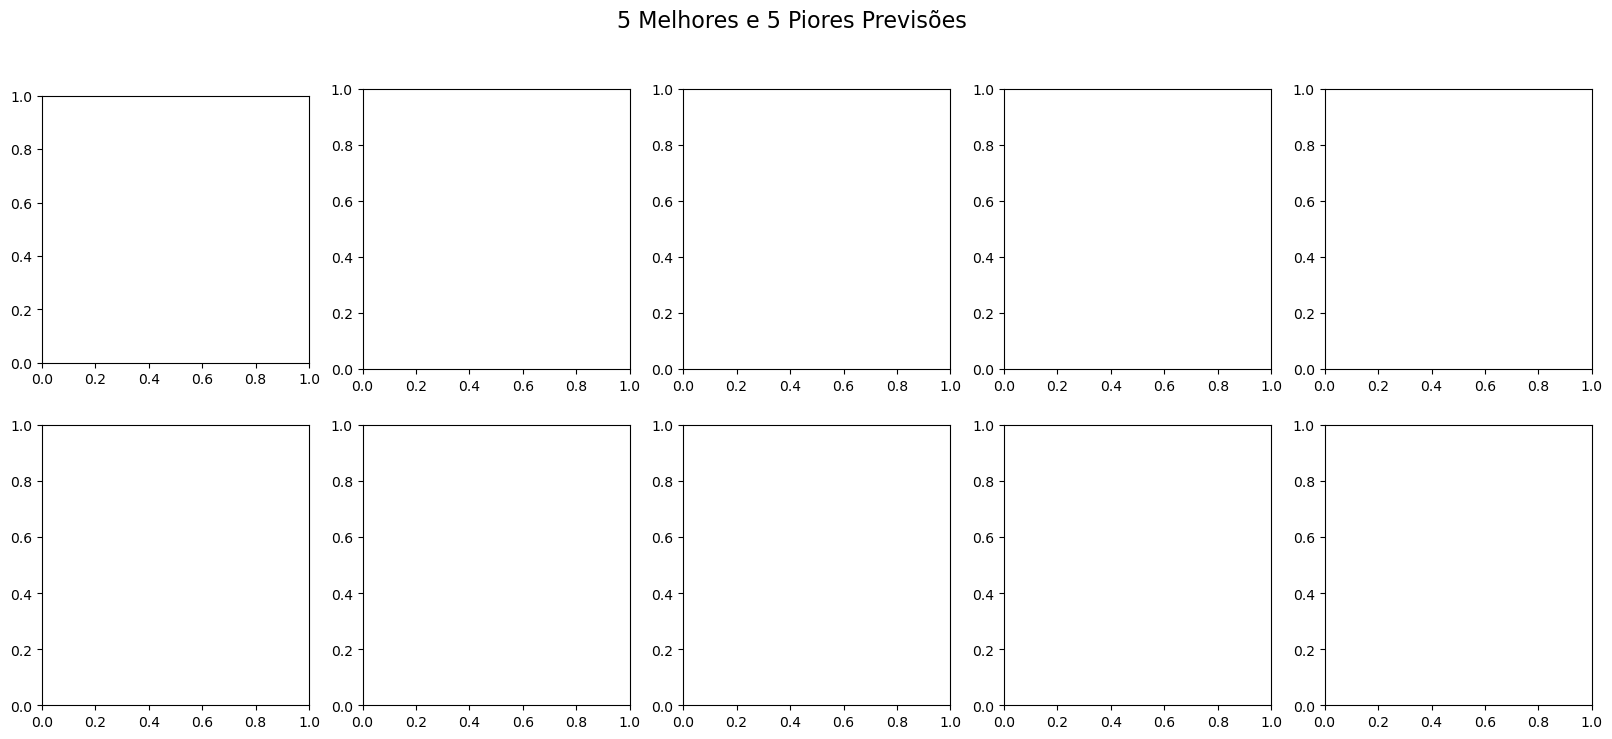

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Supondo que X_test, y_test e y_pred já estão definidos
# X_test = ...
# y_test = ...
# y_pred = ...

# Ajustar a função para plotar uma imagem com o coeficiente real e predito
def plot_image_with_values(index, ax):
    ax.imshow(X_test[index])
    ax.axis('off')  # Remove os eixos
    
    # Adicionar o coeficiente real e predito como texto na imagem
    textstr = f'Real: {y_test[index]:.4f}\nPredito: {y_pred[index]:.4f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

# Calcular os erros absolutos das previsões
errors = np.abs(y_test - y_pred)

# Índices dos 5 maiores e 5 menores erros
worst_indices = np.argsort(errors)[-5:]
best_indices = np.argsort(errors)[:5]

# Criar subplots para as 5 melhores e 5 piores previsões
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('5 Melhores e 5 Piores Previsões', fontsize=16)

# Plotar as 5 melhores previsões
for i, ax in enumerate(axes[0, :]):
    plot_image_with_values(best_indices[i], ax)
    ax.set_title(f'Melhor {i+1}')

# Plotar as 5 piores previsões
for i, ax in enumerate(axes[1, :]):
    plot_image_with_values(worst_indices[i], ax)
    ax.set_title(f'Pior {i+1}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar o layout para evitar sobreposições
plt.show()


0.76


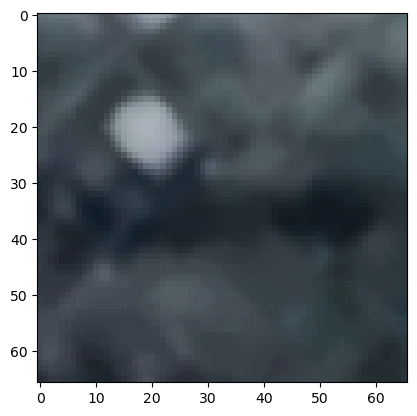

In [37]:
index = 0
plt.imshow(df_images.at[index, 'image'])
print(df_images.at[index, 'coefficient'])
